In [19]:
import json
import random
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.ticker import MultipleLocator
from collections import Counter
import networkx as nx 

In [20]:
try:
    with open('community_detection.json', 'r', encoding='utf-8') as f:
        community_data = json.load(f)
except UnicodeDecodeError:
    with open('community_detection.json', 'r', encoding='ISO-8859-1') as f:
        community_data = json.load(f)

try:
    with open('user_features.json', 'r', encoding='utf-8') as f:
        user_features = json.load(f)
except UnicodeDecodeError:
    with open('user_features.json', 'r', encoding='ISO-8859-1') as f:
        user_features = json.load(f)

print(f"Number of nodes in community data: {len(community_data)}")
print(f"Number of nodes in user features: {len(user_features)}")
print(f"Number of communities: {len(set(community_data.values()))}")

Number of nodes in community data: 81306
Number of nodes in user features: 81306
Number of communities: 73


In [21]:
# Sample number of communities and nodes per community to analyze
num_communities = 20  
nodes_per_community = 250 

# community IDs
unique_communities = list(set(community_data.values()))

sampled_communities = random.sample(unique_communities, num_communities)
sampled_nodes = {}
for community_id in sampled_communities:
    community_nodes = [node for node, comm in community_data.items() if comm == community_id]
    sampled_nodes[community_id] = random.sample(community_nodes, min(len(community_nodes), nodes_per_community))

sampled_nodes

{3: ['20099276',
  '48504743',
  '56798948',
  '28931188',
  '211336533',
  '143838260',
  '147269043',
  '530817071',
  '208105146',
  '21142831',
  '226516599',
  '58664407',
  '20008935',
  '22729358',
  '243227325',
  '58309829',
  '55479130',
  '56196884',
  '232278699',
  '75036762',
  '480595611',
  '462631487',
  '225135025',
  '29860364',
  '85120815',
  '170802477',
  '47674653',
  '61658727',
  '37826416',
  '177388963',
  '240944206',
  '55406446',
  '238771250',
  '338380084',
  '154530574',
  '51186735',
  '15087120',
  '19355813',
  '273928586',
  '265034798',
  '201035805',
  '171704225',
  '70786238',
  '250870513',
  '103937052',
  '51246584',
  '189983595',
  '235163686',
  '192023970',
  '17093604',
  '112819301',
  '61661467',
  '113713593',
  '345502810',
  '50037051',
  '34507480',
  '126470482',
  '388006347',
  '146613557',
  '318581105',
  '81216996',
  '214069146',
  '129069705',
  '155938168',
  '83766944',
  '123670656',
  '106264732',
  '170237115',
  '151

In [22]:
# Print selected users and features in communities
for community_id, nodes in sampled_nodes.items():
    print(f"\nCommunity {community_id}:")
    for node in nodes:
        features = user_features.get(str(node), [])
        print(f"  Node {node} features: {features}")


Community 3:
  Node 20099276 features: ['@KehhBuchmann', '@janessacamargo', '@IsabelaaFreitas:', '@thuthuzera', '@nathbacci', '@crawletas', '@crawletas:']
  Node 48504743 features: ['#3', '@SPINmagazine:', '@iTunesMusic', '@OneDirection', '@onedirection:']
  Node 56798948 features: ['@pecesiqueira:', '@BotafogoNews:']
  Node 28931188 features: ['@AvrilLavigne', '@FrasesDeRenato:', '@TrechosDoRock:', '@tommcfly:', '@Myriam_Avril:', '@UnitedForAvril:']
  Node 211336533 features: ['#RT', '@AvrilLavigne', '@AvrilLavigne:', '@youtube', '@Nickelback', '@News_Avril:', '#LittleBlackStars!', '#abbeydawn4jf', '@AvrilSincera_:', '@BrodyJenner', '@GABRIELPANDURO:', '@JustFabOnline:', '@Proactiv:', '@TheRealDevinB:', '@UnitedForAvril:', '@abbeydawn', '@avrilmidia:', '@danielridieri:']
  Node 143838260 features: ['#nowplaying', '@MirandaCosgrove:', '#Ilovethissong', '#Mustsee', '#confused', '#greatsong', '@AlexMelodeeSol', '@Andybarrandy', '@Carcla16', '@CarlyMarieC', '@Chewiejds', '@Heloyza_C', '@

In [23]:
# jaccard similarity
def calculate_jaccard(set1, set2):
    if not set1 and not set2:  # Both sets are empty
        return 0.0
    intersection = len(set1.intersection(set2))
    union = len(set1.union(set2))
    return intersection / union


In [24]:
similarity_scores = []
for community_id, nodes in sampled_nodes.items():
    # Calculate within-community similarity
    for i in range(len(nodes)):
        for j in range(i + 1, len(nodes)):
            features1 = set(user_features.get(str(nodes[i]), []))
            features2 = set(user_features.get(str(nodes[j]), []))
            similarity = calculate_jaccard(features1, features2)
            similarity_scores.append({'Community': community_id, 'Type': 'Within', 'Similarity': similarity})
    
    # Calculate between-community similarity
    other_nodes = [node for other_id, other_nodes in sampled_nodes.items() if other_id != community_id for node in other_nodes]
    for node1 in nodes:
        features1 = set(user_features.get(str(node1), []))
        for node2 in other_nodes:
            features2 = set(user_features.get(str(node2), []))
            similarity = calculate_jaccard(features1, features2)
            similarity_scores.append({'Community': community_id, 'Type': 'Between', 'Similarity': similarity})

similarity_df = pd.DataFrame(similarity_scores)
similarity_df


,Community,Type,Similarity
0,3,Within,0.0
1,3,Within,0.0
2,3,Within,0.0
3,3,Within,0.0
4,3,Within,0.0
...,...,...,...
17835256,5,Between,0.0
17835257,5,Between,0.0
17835258,5,Between,0.0
17835259,5,Between,0.0


In [25]:
# Calculate average similarities
average_similarities = similarity_df.groupby('Type')['Similarity'].mean().reset_index()

print("Average Similarities:")
print(average_similarities)

Average Similarities:
      Type  Similarity
0  Between    0.000729
1   Within    0.005149


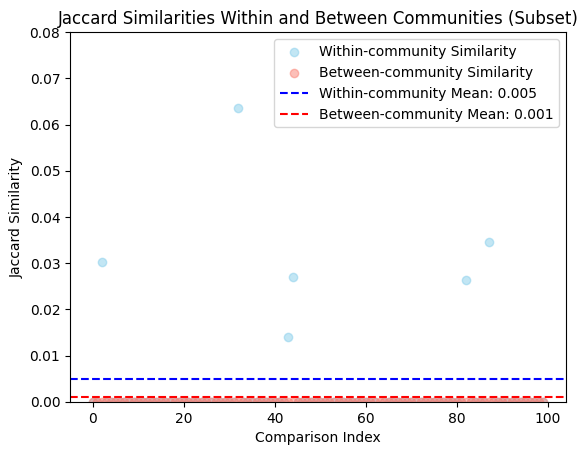

In [26]:
within_mean = average_similarities[average_similarities['Type'] == 'Within']['Similarity'].values[0]
between_mean = average_similarities[average_similarities['Type'] == 'Between']['Similarity'].values[0]

# Round the averages to thousandths place
within_mean = round(within_mean, 3)
between_mean = round(between_mean, 3)

# Sample size for plot - an equal number of 'Within' and 'Between' nodes
sample_size = 100 
within_sample_df = similarity_df[similarity_df['Type'] == 'Within'].sample(n=sample_size, random_state=42)
between_sample_df = similarity_df[similarity_df['Type'] == 'Between'].sample(n=sample_size, random_state=42)

# Extract similarities
within_similarities = within_sample_df['Similarity'].values
between_similarities = between_sample_df['Similarity'].values

# Plot
within_index = np.arange(len(within_similarities))
between_index = np.arange(len(between_similarities))
plt.scatter(within_index, within_similarities, color='skyblue', label='Within-community Similarity', alpha=0.5)
plt.scatter(between_index, between_similarities, color='salmon', label='Between-community Similarity', alpha=0.5)

# horizontal lines for the average similarities
plt.axhline(within_mean, color='blue', linestyle='--', label=f'Within-community Mean: {within_mean:.3f}')
plt.axhline(between_mean, color='red', linestyle='--', label=f'Between-community Mean: {between_mean:.3f}')

# Labels
plt.xlabel("Comparison Index")
plt.ylabel("Jaccard Similarity")
plt.title("Jaccard Similarities Within and Between Communities (Subset)")

plt.ylim(0, 0.08)  
plt.gca().yaxis.set_major_locator(MultipleLocator(0.01)) 
plt.legend()
plt.show()


In [27]:
# Define categories (tags, hashtags, and other)
categories = {
    "tags": lambda x: x.startswith("@"),  # mentions
    "hashtags": lambda x: x.startswith("#"),  # hashtags
    "other": lambda x: not x.startswith("@") and not x.startswith("#")  # Everything else
}

# Count feature types in each community
category_counts = {community_id: Counter() for community_id in sampled_nodes}

for community_id, nodes in sampled_nodes.items():
    for node in nodes:
        features = user_features.get(str(node), [])
        for feature in features:
            for category, condition in categories.items():
                if condition(feature):
                    category_counts[community_id][category] += 1

# category frequencies for each community
category_counts


{3: Counter({'tags': 2619, 'hashtags': 497}),
 71: Counter({'tags': 412, 'hashtags': 131}),
 25: Counter({'hashtags': 801, 'tags': 2780, 'other': 4}),
 69: Counter({'hashtags': 996, 'tags': 3541}),
 53: Counter({'hashtags': 258, 'tags': 372}),
 28: Counter({'hashtags': 702, 'tags': 3378}),
 57: Counter({'tags': 2355, 'hashtags': 735, 'other': 6}),
 35: Counter({'tags': 1702, 'hashtags': 811, 'other': 1}),
 0: Counter({'tags': 2735, 'hashtags': 443}),
 20: Counter({'hashtags': 1204, 'tags': 3003, 'other': 1}),
 44: Counter({'tags': 2095, 'hashtags': 1562, 'other': 2}),
 27: Counter({'hashtags': 61, 'tags': 1889}),
 21: Counter({'hashtags': 922, 'tags': 2609, 'other': 1}),
 17: Counter({'hashtags': 896, 'tags': 2151, 'other': 1}),
 9: Counter({'tags': 2742, 'hashtags': 454}),
 13: Counter({'tags': 2381, 'hashtags': 783}),
 48: Counter({'hashtags': 416, 'tags': 4123}),
 60: Counter({'hashtags': 365, 'tags': 1168}),
 6: Counter({'hashtags': 1173, 'tags': 2500}),
 5: Counter({'hashtags': 72

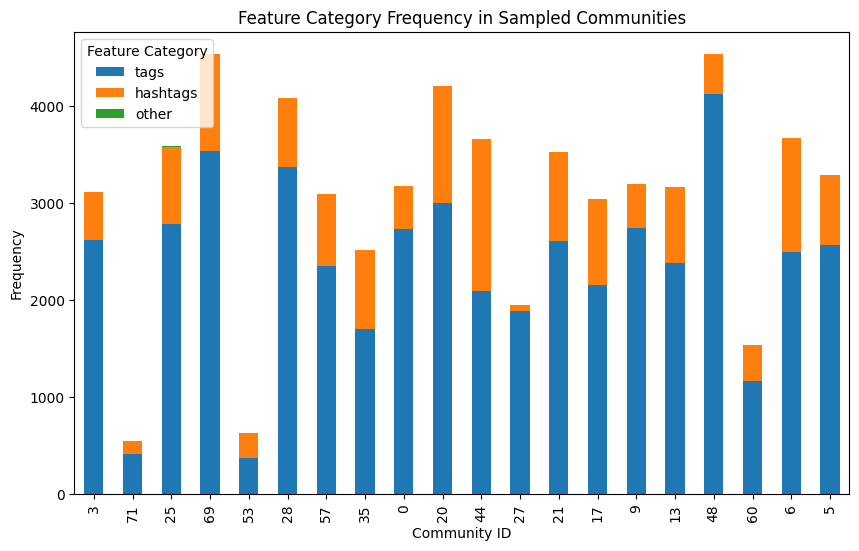

In [28]:
category_df = pd.DataFrame.from_dict(category_counts, orient='index').fillna(0)

# Plot
category_df.plot(kind='bar', stacked=True, figsize=(10, 6))
plt.title("Feature Category Frequency in Sampled Communities")
plt.xlabel("Community ID")
plt.ylabel("Frequency")
plt.legend(title="Feature Category")
plt.show()


Category Percentages: {'tags': 78.42442815772101, 'hashtags': 21.53854926091363, 'other': 0.03702258136535425}


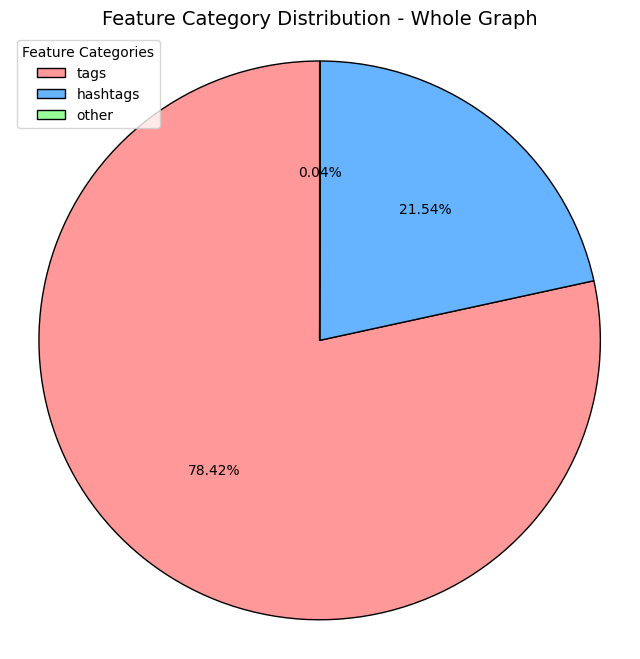

In [29]:
with open('graph_layout.json', 'r', encoding='utf-8') as f:
    layout_data = json.load(f)

# Create a graph
G = nx.Graph()
for node in layout_data.keys():
    G.add_node(int(node))

all_nodes = list(G.nodes)

# categories (tags, hashtags, and other)
categories = {
    "tags": lambda x: x.startswith("@"),  # Mentions/tags
    "hashtags": lambda x: x.startswith("#"),  # Hashtags
    "other": lambda x: not x.startswith("@") and not x.startswith("#")  # Everything else
}

# Count feature types across the graph
feature_counts = Counter()
for node in all_nodes:  
    features = user_features.get(str(node), [])  
    for feature in features:
        for category, condition in categories.items():
            if condition(feature):
                feature_counts[category] += 1

# total number of features
total_features = sum(feature_counts.values())

# percentages for each category
category_percentages = {category: count / total_features * 100 for category, count in feature_counts.items()}
print(f"Category Percentages: {category_percentages}")

labels = category_percentages.keys()
sizes = category_percentages.values()
colors = ['#ff9999', '#66b3ff', '#99ff99']  # Colors for categories

# Plot
plt.figure(figsize=(8, 8))
plt.pie(sizes, colors=colors, autopct='%1.2f%%', startangle=90, wedgeprops={'edgecolor': 'black'})

plt.legend(labels=labels, loc='upper left', title='Feature Categories', fontsize=10, frameon=True)
plt.title('Feature Category Distribution - Whole Graph', fontsize=14)
plt.axis('equal')

plt.show()



   Community     Node1      Node2                                Category
0         69  42464314  345336479  {'tags': 1, 'hashtags': 0, 'other': 0}
1         69  42464314  148148803  {'tags': 0, 'hashtags': 0, 'other': 0}
2         69  42464314  134162887  {'tags': 0, 'hashtags': 0, 'other': 0}
3         69  42464314  217511904  {'tags': 0, 'hashtags': 0, 'other': 0}
4         69  42464314  134171620  {'tags': 1, 'hashtags': 0, 'other': 0}
Category Counts of Similarities:
tags         9192
hashtags    12293
other           0
dtype: int64
Category Percentages of Similarities:
tags        42.783337
hashtags    57.216663
other        0.000000
dtype: float64


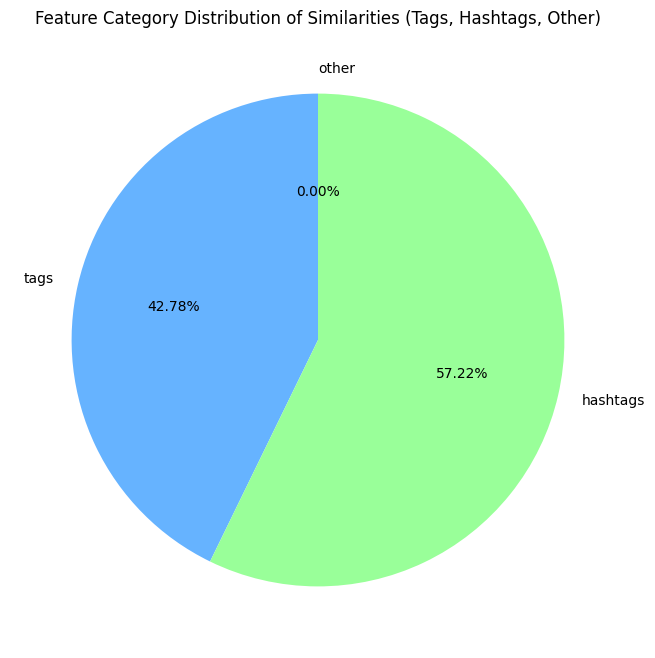

In [35]:
random.seed(42)

# smaller sample size
sample_community_size = 10  
sample_node_size = 100      

# Sample a subset of communities and nodes
sampled_communities_subset = random.sample(list(sampled_nodes.items()), sample_community_size)
sampled_nodes_subset = {community_id: random.sample(nodes, min(sample_node_size, len(nodes))) 
                        for community_id, nodes in sampled_communities_subset}

categories = {
    "tags": lambda x: x.startswith("@"),
    "hashtags": lambda x: x.startswith("#"),
    "other": lambda x: not x.startswith("@") and not x.startswith("#")  # Everything else
}

# categorize features 
def categorize_features(features):
    categories_for_features = {'tags': 0, 'hashtags': 0, 'other': 0}
    for feature in features:
        for category, condition in categories.items():
            if condition(feature):
                categories_for_features[category] += 1
    return categories_for_features

def calculate_similarity_and_categories(node1, node2, community_id):
    features1 = set(user_features.get(str(node1), []))
    features2 = set(user_features.get(str(node2), []))
    
    # common features between the two nodes 
    common_features = features1.intersection(features2)
    
    # put features into categories 
    category_counts = {'tags': 0, 'hashtags': 0, 'other': 0}
    
    # number common features in each category
    for feature in common_features:
        category_counts.update(categorize_features([feature])) 
        
    return {
        'Community': community_id,
        'Node1': node1,
        'Node2': node2,
        'Category': category_counts
    }

# recompute similarity considering catergory 
similarity_scores = []
for community_id, nodes in sampled_nodes_subset.items():
    # Calculate within-community similarity
    for i in range(len(nodes)):
        for j in range(i + 1, len(nodes)):
            similarity_scores.append(
                calculate_similarity_and_categories(nodes[i], nodes[j], community_id)
            )
    
    # Calculate between-community similarity
    other_nodes = [node for other_id, other_nodes in sampled_nodes_subset.items() if other_id != community_id for node in other_nodes]
    for node1 in nodes:
        for node2 in other_nodes:
            similarity_scores.append(
                calculate_similarity_and_categories(node1, node2, community_id)
            )

similarity_df = pd.DataFrame(similarity_scores)
print(similarity_df.head())

# occurrences of each category type
category_counts = similarity_df['Category'].apply(pd.Series).sum()
print("Category Counts of Similarities:")
print(category_counts)

# percentages of each category
total_similarities = category_counts.sum()
category_percentages = (category_counts / total_similarities) * 100
print("Category Percentages of Similarities:")
print(category_percentages)

# plot
plt.figure(figsize=(8, 8))
plt.pie(category_percentages, labels=category_percentages.index, autopct='%1.2f%%', startangle=90, colors=['#66b3ff', '#99ff99', '#ff6666'])
plt.title('Feature Category Distribution of Similarities (Tags, Hashtags, Other)')
plt.show()


In [ ]:
random.seed(42)
similarity_scores = []

for community_id, nodes in sampled_nodes_subset.items():
    # Calculate within-community similarity
    for i in range(len(nodes)):
        for j in range(i + 1, len(nodes)):
            result = calculate_similarity_and_categories(nodes[i], nodes[j], community_id)
            if result:
                similarity_scores.append(result)
    
    # Calculate between-community similarity
    other_nodes = [node for other_id, other_nodes in sampled_nodes_subset.items() if other_id != community_id for node in other_nodes]
    for node1 in nodes:
        for node2 in other_nodes:
            result = calculate_similarity_and_categories(node1, node2, community_id)
            if result:
                similarity_scores.append(result)

similarity_df = pd.DataFrame(similarity_scores)
print(similarity_df.head())

# Print some of the common features for pairs
for idx, row in similarity_df.iterrows():
    print(f"Community: {row['Community']}, Node1: {row['Node1']}, Node2: {row['Node2']}")
    print(f"Common Features: {row['Common_Features']}")
    print(f"Category Counts: {row['Category']}\n")
    if idx >= 5:  # Limit to first 5 rows for brevity
        break


   Community      Node1      Node2  Similarity Common_Features  \
0         69  223318094  505284767           1     {@_kosher:}   
1         69  223318094  526018795           1     {@_kosher:}   
2         69  223318094  286798907           1     {@_kosher:}   
3         69  223318094  135180346           1       {#Salute}   
4         69  223318094  198040795           1     {@_kosher:}   

                                 Category  
0  {'tags': 1, 'hashtags': 0, 'other': 0}  
1  {'tags': 1, 'hashtags': 0, 'other': 0}  
2  {'tags': 1, 'hashtags': 0, 'other': 0}  
3  {'tags': 0, 'hashtags': 1, 'other': 0}  
4  {'tags': 1, 'hashtags': 0, 'other': 0}  
Community: 69, Node1: 223318094, Node2: 505284767
Common Features: {'@_kosher:'}
Category Counts: {'tags': 1, 'hashtags': 0, 'other': 0}

Community: 69, Node1: 223318094, Node2: 526018795
Common Features: {'@_kosher:'}
Category Counts: {'tags': 1, 'hashtags': 0, 'other': 0}

Community: 69, Node1: 223318094, Node2: 286798907
Common Featur